# Distributing Python work between processes and threads on a single machine using the joblib package

A common problems in research computing is needing to **apply the same processing** to **many distinct sets of inputs** e.g. for sensitivity analyses or parametric studies. 

This can broadly be conceptualised as wanting to apply 
a function, $analysis(a, b) \rightarrow c$, to 
each of $n$ sets of arguments e.g. $((a_1, b_1), (a_2, b_2), \ldots (a_n, b_n))$.

There are several ways to go about this:

1.  Call $f$ **many times in sequence**, passing in a different argument each time, 
    which is simple to express in code but slow as function calls run in series, or
1.  If using HPC, tell the **HPC job scheduler** (e.g. Grid Engine) that you want to run $n$ independent tasks and 
    [let it schedule them, ideally in parallel](http://docs.hpc.shef.ac.uk/en/latest/parallel/JobArray.html).  
    You will need to aggregate the function outputs from text files though.
1.  Thirdly, you could run those tasks in parallel from inside your programming environment (e.g. Python, R, MATLAB).
    This could be very convenient once you have learned how to do so as 
    all pre and post-processing can be done the same environment 
    without necessarily needing to read/write files from disk.
 
Here we focus on the third of these options, 
looking at how the `joblib` library lets us distribute tasks between the multiple CPU cores of a machine. 

## Learning outcomes

By the end of this tutorial you should be able to:

* Explain the basic differences between multprocessing and multithreading and why only multiprocessing is typically used in *pure* Python programs.
* Parallelise embarrasingly parallel problems by *mapping* a function over a sequence of arguments using the `joblib` package
* Explain the two ways in which `joblib` can share data with worker processes
* Be able to explicitly create and use memory-mapped files for efficient sharing of data between processes. 
* Explain the advantages and disadvantages of the `multiprocessing` and `multithreading` backends of the `joblib` package.
* Explain why `joblib` is used over `multiprocessing` in Jupyter Notebooks

## Setup if using JupyterHub on ShARC

If you want to run through this tutorial on ShARC please follow the setup instructions for the [multi-threading tutorial](01-multithreading.ipynb) with the following exceptions:
  - Create your conda environment using
  
    ```
    conda env create -n hi-perf-ipynb-multiprocessing -f 02-multiprocessing-env.yml
    ```

 - Select that environment within Jupyter using 
      * Click *Kernel* -> *Change Kernel*
      * Select `Python [conda env:hi-perf-ipynb-multiprocessing]`
      
As per the multithreading tutorial, you should request 4 CPU cores and 4GB of RAM per core.

## Introduction

In the previous tutorial, we saw how we could use Python packages to interact with compiled, non-Python, multi-threaded libraries to speed up linear algebra and FFTW operations by distributing
 work between multiple CPU cores.  Distributing work between threads (and cores) required little effort on our part but we were restricted using just the functions provided by numpy+MKL and 
pyFFTW+FFTW.  What if we want to parallelise code we have written ourselves?

The simplest case is parallelising some Python code so that we can execute it on multiple CPU cores within a single machine.  Before we get into some examples that demonstrate this we first 
need to know a little more about the distinction between **threads** and **processes** and about the Python **Global Interpreter Lock (GIL)** .

## Some background: multi-processing, multi-threading and the Python Global Interpretter Lock (GIL)

### Operating system *processes*

When we execute a program we get a **process**, which is a running instance of the program.  The operating system manages the execution of many processes.  Associated each process is:

* memory containing the program's instructions
* memory containing the program's data (e.g. variables and constants)
* process metadata

One simple way of achieving parallelism is to run multiple related instances of the same program on a single machine: the program is written so that the first process be started includes an instruction to **fork** (spawn) a (*child*) process and subsequently both processes are able to run in parallel (ideally on separate CPU cores) until one/both exits.  Forking is quite an expensive operation in terms of time and memory as the parent process's memory containing its instructions and data is all copied to the child process.  The (single) program includes separate logic per process, which are differentiated at run-time by the process ID.  In over-simplified pseudo-code this looks something like:

```
process_id = fork();
if process_id == some_value: 
    # do something specific to the child process
    thing_one()
else:
    # do something specific to the parent process
    thing_two()
# the parent process waits for the child to exit
wait()   
```

In the above example both thing_one and thing_two can execute at the same time and use their individual copies of the data (which may diverge after the fork).

### Process threads

A second common approach to single-machine parallelism is multithreading.  Parallelism is achieved by a process internally spawning a additional strand of execution known as a thread, rather than forking a separate child process.  Creating threads is much cheaper than creating processes as all threads within a process (including the initial thread) **share memory**: there is no need to create copies of the program's instructions and of the process's data when a new thread is spawned.  Multi-threading is therefore *usually* preferable to multi-processing for efficient parallelism on a single machine.  However, coordinating multiple threads to ensure they don't trip over each other when accessing the same data strucures can be hard *if tasks aren't independent*.

### The Python Global Interpreter Lock

Although multi-threading is used a lot when programming in languages such as C or Java, **multi-threading is often only of very limited use in Python code**.  This is because for a Python thread to do computation it must hold a per-Python-process resource known as the **Global Intepreter Lock** (GIL).  Any thread that does not hold the GIL must wait for it to become free then successfully acquire it before it can do any computation.  The effect is that **only one of the threads of a Python process can do computational work at any given time**.  The need for the GIL relates to fundamental design decisions made early in the development of the most popular Python interpretter (cPython); many developers would like to find a way to free multi-threaded Python from the shackles of the GIL but that is [not a trivial problem to solve](https://docs.python.org/3/c-api/init.html#thread-state-and-the-global-interpreter-lock).  

Note: if a Python function calls a non-Python function (e.g. a MKL function) then the non-Python function is not aware of the GIL not bound by it so can spawn multiple threads.  This is what happens when we use the MKL library via numpy and the FFTW library via pyFFTW.

---
So, in summary 

* If we want to parallelise a single Python program so it can distribute computation between the multiple cores of a single machine we must use **multi-processing** then we must fork off child Python processes, each with their own data and instruction memory segments.  
* If our Python program calls non-Python parts these can internally use multi-threading, where threads are quick to create and can share memory by default.

## Parallel 'function mapping' with joblib

A popular Python library for distributing and collating work using multi-processing is [joblib](https://pythonhosted.org/joblib/parallel.html).  This [isn't the only thing joblib can do](https://pythonhosted.org/joblib/#main-features) but that's what we're going to focus on here.

joblib helps when problems are **embarrasingly parallel** i.e. when the tasks that are conducted in parallel can be executed in isolation without any need for inter-task communication (except at the very start and end of course).  

Let's look at a simple example [from the joblib documentation](https://pythonhosted.org/joblib/parallel.html#embarrassingly-parallel-for-loops).  First, here's some serial code that, for each number in an [iterable](https://docs.python.org/3/glossary.html), squares the number then takes the square root:

In [1]:
from math import sqrt

%timeit -n 5 [sqrt(i ** 2) for i in range(20)]

18.1 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Some general terminology: here we have **mapped** the function `sqrt(i ** 2)` over a range of values, `range(20)`, to generate a new range of values (which in this case we throw away).  

Also, note that here we use the `%timeit` IPython '[magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html)' function to time a Python statement in our Notebook, but in the multithreading tutorial we used the `timeit` module instead.  This is because `%timeit` doesn't work well when called within functions but we don't define any in this Notebook.

Now let's see how we can use `joblib` to distribute that work between two processes:

In [2]:
from joblib import Parallel, delayed

%timeit -n 5 Parallel(n_jobs=4)(delayed(sqrt)(i ** 2) for i in range(10))

161 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


You will notice that that's *much slower*!  Why?

Well, the overhead of 

1. creating separate worker processes, 
2. ensuring the necessary code and data is available to those processes then
3. collating results from those processes 

dominates the execution time.  

We need to **make sure we give each worker sufficient work so that these overheads are far less significant**.

## Work pools

So, here we had 4 CPU cores and 20 tasks - how was the labour divided up?  

joblib uses what's called a **work pool** approach: it has a **set of tasks to be run** and each time a 'worker' process (ideally corresponding to one CPU core) falls idle `joblib` gives it a new task from that set. 

## Deciding on the number of jobs/workers automatically

Above we distribute the work between 4 processes and that number is a hard-coded argument to `Parallel`. 
Let's see if can dynamically determine how many processes to create. 

We want one per **available physical core** i.e. 

 * ignore hyperthreading
 * ignore processors that are unavailable to us (e.g. as they have been allocated to other jobs on a Grid Engine cluster)
 
Reasons are given in the [multithreading tutorial](01-multithreading.ipynb).

Unfortunately there's no nice way of discovering this information from Python, but if the `lstopo` command-line utility is available (see  the [multithreading tutorial](01-multithreading.ipynb)) we can use that:

In [3]:
import subprocess
import sys
import os

# Running the lstopo command-line tool like this generates a line of output per physical core 
lines = subprocess.check_output(['lstopo',  '--restrict', 'binding', '--only', 'core']) \
                  .decode(sys.stdout.encoding) \
                  .strip() \
                  .split(os.linesep)
n_phys_cores = len(lines)

In [4]:
n_jobs = n_phys_cores
n_jobs

4

Alternatively, if you are running your code on a Grid Engine cluster such as ShARC then this one-liner should suffice:

In [5]:
# Pick up the number of cores allocated to our job using an environment variable set by Grid Engine
n_jobs = int(os.environ['NSLOTS'])
n_jobs

4

## More work please!

We said multiprocessing is only efficient if each process has a non-trivial amount of work to do. 

Let's look at applying a [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) to an iterable (sequence) of (dummy) images. As with the previous example, each element of the iterable can be processed independently (an *embarrasingly parallel* problem) but here the function applied to each element is much more computationally intensive.

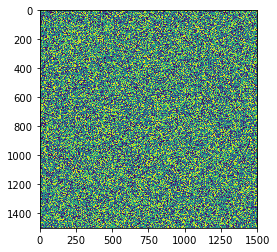

In [6]:
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create a sequence of n_imgs 'images' (img_size x img_size random square matrixes)
img_side = 1500
n_imgs = 7
img_set = [np.random.rand(img_side, img_side) for i in range(n_imgs)]

def blur_it(matr):
    # Apply a Gaussian filter to a numpy array, 'matr'
    return gaussian_filter(matr, sigma=50, order=0, output=None, 
                           mode='reflect', cval=0.0, truncate=4.0)

# The first image in our sequence
plt.imshow(img_set[0]);

Let's **time the serial application of the function** to all 7 'images':

In [7]:
# Preallocate memory in this process to make sure that we are not profiling that too
blurred_imgs = [np.zeros_like(img_set[0]) for img in img_set]

In [8]:
%timeit -n1 -r3 blurred_imgs = [blur_it(img) for img in img_set]

6.72 s ± 89.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


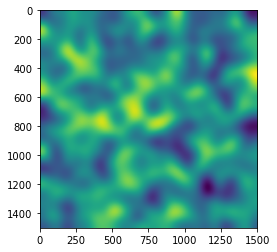

In [9]:
# %timeit does not update the blurred_imgs variable that is in scope
# so let's call it once more
blurred_imgs = [blur_it(img) for img in img_set]
plt.imshow(blurred_imgs[0]);

And time the application of the function to all images **using `joblib` and 4 processes**:

2.79 s ± 60.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


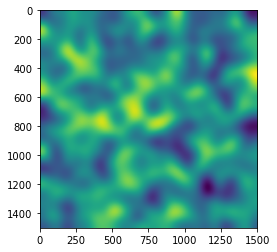

In [10]:
%timeit -n1 -r3 blurred_imgs = Parallel(n_jobs=n_jobs)(delayed(blur_it)(img) for img in img_set)

# Again, we need to re-run the step we've just timed as we cannot save the output from it in this scope
blurred_imgs = Parallel(n_jobs=n_jobs)(delayed(blur_it)(img) for img in img_set)
plt.imshow(blurred_imgs[0]);

The function is sufficiently expensive that the parallelisation overheads are less significant.

However, we're getting much less than 4x speedup with 4 processes vs 1 process.  This could be due to the transferring of data between processes being expensive for the amount of computation conducted.

## joblib + multiprocessing: sharing task inputs using shared memory 

So, if joblib distributes work between processes and processes by default don't share any memory **how do our input images get from our master process to the 'slave' processes** that apply our Gaussian blur?  

joblib offers two mechanisms:

1. For Python objects under a certain size joblib transmits the objects' data from the master process to the slave and the slave then gets its own copies of those objects (with implications for overall memory utilisation).  This way of **transferring data between processes** relies on what in Python is called **pickling** or more generally is called **serialisation**, which is a means for turning Python objects into a stream of bytes that can be sent to other processes (or can be saved to disk or sent over a network).  
2. For larger Python objects, joblib tries to avoid the worker processes having to allocate additional memory: the memory per machine is finite and memory alocation is not instantaneous.  Processes cannot share their own memory but they can potentially **use [memory-mapped files](https://en.wikipedia.org/wiki/Memory-mapped_file) as common memory**.  A memory-mapped file can be used like ordinary memory for storing data but the **underlying storage is a file rather than RAM**.  By default joblib will share large objects between processes using memory-mapped files in the `/dev/shm` filesystem (on Linux/macOS), which is a filesystem that exists entirely in memory!  If that is not possible then a temporary file elsewhere is created/used (which will be slower if it is written to disk). 

**In short**: sharing data using memory-mapped files is more efficient than pickling/serialisation in terms of memory duplication but comes with overheads; we therefore want to use shared memory just for making larger Python objects available to our worker processes.

So, will joblib use pickling or shared memory to share our set of images with our workers?  We can check with joblib's `has_shareable_memory` function:

In [11]:
from joblib.pool import has_shareable_memory

Parallel(n_jobs=n_jobs)(
    delayed(has_shareable_memory)(img)
    for img in img_set)

[True, True, True, True, True, True, True]

Yes, our objects are large enough for us to joblib to share them with workers using shared memory:

We can tune the thresholds used for switching between the two transfer methods by passing a `max_nbytes` parameter  to `Parallel`.  If we ramp this up from the default of 1MB to say 50MB then joblib will revert to pickling our images to share them with workers: 

In [12]:
Parallel(n_jobs=n_jobs, max_nbytes="50M")(
    delayed(has_shareable_memory)(img)
    for img in img_set)

[False, False, False, False, False, False, False]

Does that make a difference in our case?  

In [13]:
%timeit -n1 -r3 blurred_imgs = Parallel(n_jobs=n_jobs, max_nbytes="50M")(delayed(blur_it)(img) for img in img_set)

2.74 s ± 91.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


For me, increasing `max_nbytes` to force the use of pickling *improved* performance, but not by much.  However, tuning `max_nbytes` may make a difference for other problem(s) where the overheads of managing shared memory are less significant.

## joblib + multiprocessing: sharing task inputs + outputs using shared memory 

joblib may by default distribute large inputs efficiently using shared memory.  Can we also used shared memory to **collate the results of our computation** and **save on memory allocation/duplication costs**?  Yes, but this requires some manual management of memory-mapped files, as by default the memory-mapped files created by the master process are read-only for workers.

First, let's rewrite our Gaussian blur function so it provides a result by mutating one of its arguments rather than returning an object:

In [14]:
def blur_it_2_arg(matr_in, matr_out):
    # Gaussian blur function that takes its input from one argument and
    # writes its output to the second argument
    gaussian_filter(matr_in, sigma=50, order=0, output=matr_out, 
                           mode='reflect', cval=0.0, truncate=4.0)
    return

Next, let's apply that in parallel using a read-only memory-mapped input 3D ndarray as input and a writable memory-mapped input 3D ndarray to store the output:

Shape of img_set_np: (7, 1500, 1500)

blurred_imgs_np is now mapped to /dev/shm/tmp0s1gampm/blurred_imgs
img_set_np is now mapped to /dev/shm/tmp0s1gampm/img_set

2.44 s ± 97.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


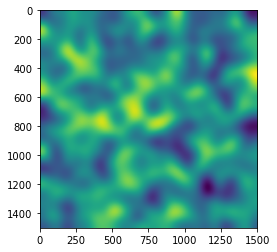

In [15]:
import tempfile 
import os

from joblib import dump, load

try:
    # Create a directory under /dev/shm to hold our memory-mapped files
    # NB /dev/shm is a filesystem that resides entirely in memory rather than on disk. 
    tmpdir = tempfile.mkdtemp(dir=os.path.join(os.path.sep, 'dev', 'shm'))
    
    # Names of the files that we will later used for memory-mapping
    img_set_file = os.path.join(tmpdir, 'img_set')  # for input data
    blurred_imgs_file = os.path.join(tmpdir, 'blurred_imgs')  # for output data 

    # Let's restructure our input data as a 3D numpy ndarray, 
    # as this allows us to memory-mapp our input data using numpy's memmap function 
    img_set_np = np.asarray(img_set, order=3)
    print("Shape of img_set_np: {}\n".format(img_set_np.shape))

    # Create a memory-mapped 3D numpy ndarray to hold our output.
    # Ensure this is writable by worker processes.
    #
    # Note that by default the permissions for this file may result in it being
    # readable by all users - be careful what you store in here!
    blurred_imgs_np = np.memmap(blurred_imgs_file, 
                                dtype=img_set_np.dtype,
                                shape=img_set_np.shape, 
                                mode='w+')
    print("blurred_imgs_np is now mapped to {}".format(blurred_imgs_np.filename))

    # Write out ('serialise') our input data to a file...
    dump(img_set_np, img_set_file)
    # Then use that to create a read-only memory-mapped ndarray with the same name 
    img_set_np = load(img_set_file, mmap_mode='r')
    print("img_set_np is now mapped to {}\n".format(img_set_np.filename))

    # Time how long it takes to apply our Gaussian blur in parallel
    %timeit -n1 -r3 Parallel(n_jobs=n_jobs)(delayed(blur_it_2_arg)(img_set_np[i], blurred_imgs_np[i]) \
                                 for i in range(img_set_np.shape[0]));
    
    # Call again as assignments in %timeit cannot modify in-scope variables 
    Parallel(n_jobs=n_jobs)(delayed(blur_it_2_arg)(img_set_np[i], blurred_imgs_np[i]) \
                                 for i in range(img_set_np.shape[0]));
    
    # Plot the first of the output images
    plt.imshow(blurred_imgs_np[0, :, :]);
finally:
    # Delete our memory-mapped files so
    # no-one else can read them
    for f in (img_set_file, blurred_imgs_file):
        os.unlink(f)
    os.rmdir(tmpdir)

For me that was the fastest approach yet.  It also required the most code though, and it required me to write data to a world-readable location, `/dev/shm`, which may not be acceptable if you are dealing with sensitive images!

## Distributing work between threads using joblib

joblib does not restrict us to just distributing work between *processes* on a single machine. 
We **can also distribute work between threads** by selecting the `threading` *backend*. 
This has the advantages that:

* there's no delay from starting 'child' processes as **threads are much quicker to create**; 
* **workers all share memory by default** without needing to create and manage memory-mapped files.

However, this typically **only offers significant speedups** if the function to be parallelised **calls non-Python code** (code that is **not subject to Python's Global Intepreter Lock**).  

Our Gaussian blur function relies on a `scipy` function that, behind the scenes, calls some compiled functions that are not written in Python (C code in `scipy`, `numpy` and the [MKL](01-multithreading.ipynb)).  Overall, we're running enough non-Python code that the `multithreading` joblib backend gives us **better performance than the multiprocessing backend**:

In [16]:
%timeit -n1 -r3 blurred_imgs = Parallel(n_jobs=n_jobs, backend="threading")(delayed(blur_it)(img_in) \
                         for img_in in img_set)

2.21 s ± 4.17 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Ordering of results

With the examples we've looked at so far each task takes a similar duration.  What if the tasks vary in duration (e.g. task 2 of $n$ finishes before task 1)?  Does the order of the iterable returned by `Parallel` differ from the order of the input iterable(s) due to some tasks finishing before others?  

No, `joblib` guarantees that order is preserved.  We can see this if we create a function that takes an object as input, waits for a random amount of time then returns that object, then use `Parallel` to apply this to each of a sequence of integers:  

In [17]:
from time import sleep

def sleeper(i):
    sleep(np.random.rand())
    return i

Parallel(n_jobs=n_jobs)(delayed(sleeper)(i) for i in range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

However, note that other parallel computing libraries/frameworks may _not_ guarantee that order is preserved when *mapping* a function over a sequence or set of inputs.   

## How many jobs (processes/threads) and tasks to use? 

* Ideally as many jobs as available physical CPU cores
* Ideally at least as many tasks as jobs.  Ideally you'd want many more tasks than jobs, particularly if tasks vary in run time, to ensure that all available CPU cores are kept busy. 

## Alternatives to joblib: what about Python's `multiprocessing` module?

Python comes with an in-built module for multiprocessing called (surprisingly enough) `multiprocessing`.  `joblib` in part builds on `multiprocesssing`.  So why not just use multiprocessing directly? 

* It's difficult to use it in environments where the function(s) that you want to apply on all workers have been defined in an interactive environmentws (e.g. within a Jupyter Notebook); it's easy to generate obscure errors or cause the Jupyter kernel to lock up or crash;
* It is more limited than joblib in what types of objects it can *pickle*/*serialise* to worker processes.

However, in some ways `multiprocessing` is more versatile.  It is recommended that you [look at its documentation](https://docs.python.org/3/library/multiprocessing.html) to see how its functionality compares to `joblib` and what additional things it can do.  

## Summary

Here we've 

* Briefly discussed the distinction between processes and threads
* Learned of the Python Global Interpreter Lock (GIL) and how it prevents two (pure) Python threads within the same process from running simultaneously
* Seen how to 'map' functions over iterable sequences in serial and, using `joblib` in parallel
* Seen how we must give each `joblib` worker process enough work to do to make using `joblib` worthwhile!
* Applied `joblib` to a meatier problem of mapping a Gaussian blur function over a sequence of images
* Explored various options for controlling how data is copied (or not) between workers and seen how if Python code calls non-Python code (and the GIL can be released) that multithreading may be the fastest option.